# Copenhagen_Networks_Study_Notebook

[paper link](https://www.nature.com/articles/s41597-019-0325-x)

[data source](https://figshare.com/articles/dataset/The_Copenhagen_Networks_Study_interaction_data/7267433/1?file=13389320)

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as matplotcolors
import matplotlib.patches as matplotpatches
from matplotlib.ticker import AutoMinorLocator
import networkx as nx
import numpy as np
import itertools
from scipy import optimize
import seaborn as sb

In [2]:
DATA_DIR = "./"
DATA_FILENAMES = {"bluetooth": "bt_symmetric.csv",
                  "calls": "calls.csv",
                  "sms": "sms.csv",
                  "facebook_friends": "fb_friends.csv",
                  "genders": "genders.csv"}

In [3]:
def LoadData(data_filename, data_dir):
    '''Loads data from |data_dir|/|data_filename|. Returns Pandas dataframe.'''
    return pd.read_csv(os.path.join(data_dir, data_filename))  

In [4]:
# dataframe creation

df_bt = LoadData(DATA_FILENAMES["bluetooth"], DATA_DIR)
# data cleaning: removing positive signal intensities
df_bt = df_bt[df_bt["rssi"] <= 0]
# data cleaning: marking contacts with non-partecipants as empty scans
df_bt["rssi"][df_bt["user_b"] == -2] = 0
df_bt["user_b"].replace(-2, -1, inplace=True)
# inserting column for strong/weak contacts
df_bt["weight"] = (df_bt["rssi"] >= -80) & (df_bt["rssi"] != 0)
print("bluetooth\n", df_bt.head())

df_calls = LoadData(DATA_FILENAMES["calls"], DATA_DIR)
print("\ncalls\n", df_calls.head())

df_sms = LoadData(DATA_FILENAMES["sms"], DATA_DIR)
print("\nsms\n", df_sms.head())

df_facebook_friends = LoadData(DATA_FILENAMES["facebook_friends"], DATA_DIR)
# data cleaning: removing self-friendships
df_facebook_friends = df_facebook_friends[df_facebook_friends["user_b"] != df_facebook_friends["# user_a"]]
print("\nfacebook friends\n", df_facebook_friends.head())

df_genders = LoadData(DATA_FILENAMES["genders"], DATA_DIR)
# data reshaping
df_genders = df_genders.set_index("# user")
reshape_dict = {1 : "female", 0 : "male"}
df_genders["gender"] = df_genders["female"].map(reshape_dict)
df_genders.drop(columns="female", inplace=True)
print("\ngenders\n", df_genders.head())

bluetooth
    # timestamp  user_a  user_b  rssi  weight
0            0       0      -1     0   False
1            0       1      -1     0   False
2            0       2      -1     0   False
3            0       3      -1     0   False
4            0       5      -1     0   False

calls
    timestamp  caller  callee  duration
0        184     300     301       121
1       3920     512     299       670
2       5623     301     300       504
3       9252     401     457        -1
4      15466     512       0         5

sms
    timestamp  sender  recipient
0         18     370        512
1         37     512        370
2        126     370        512
3        134       0        512
4        312     137        136

facebook friends
    # user_a  user_b
0         0     512
1         0     263
2         0     525
3         0     285
4         0     543

genders
        gender
# user       
0        male
2        male
3        male
4        male
5        male


# bluetooth data

In [5]:
def aggregateStrongConnections(dataframe, hrs):
    df = dataframe.copy()
    df.drop(columns="rssi", inplace=True)
    df["# timestamp"] = df["# timestamp"] // (60*60*hrs) * (60*60*hrs)
    df = df.groupby(["# timestamp","user_a","user_b"]).sum() / (60*60*hrs/5/60)
    df.reset_index(inplace=True)
    return df

In [6]:
def createTimeGraphs(dataframe):
    graphs = [nx.from_pandas_edgelist(group, source="user_a", target="user_b", edge_attr="weight")
              for t,group in dataframe.groupby("# timestamp")]
    for G in graphs:
        G.remove_node(-1)
        [G.remove_edge(*edge) for edge,weight in nx.get_edge_attributes(G,"weight").items() if weight == 0]
        nx.set_node_attributes(G, df_genders.to_dict(orient="index"))
        g_distance_dict = {(n1, n2): 1 / weight for n1, n2, weight in G.edges(data='weight')}
        nx.set_edge_attributes(G, g_distance_dict, 'distance')
    return graphs

In [7]:
def getTimestamp(week, day, hour):
    return ((week * 7 + day) * 24 + hour) * 60 * 60

In [8]:
def getLargestCC(graph_list):
    indices = [np.argmax([len(cc) for cc in nx.connected_components(G)])
           for G in graph_list]
    biggest_cc = [G.subgraph(cc) for i,G in enumerate(graph_list)
              for j,cc in enumerate(nx.connected_components(G))
              if j == indices[i]]
    return biggest_cc

In [9]:
def VisualizeBluetoothNetwork(G): 
    connected_components = [G.subgraph(c) for c in nx.connected_components(G) if len(c) > 1]
    fig, axs = plt.subplots(1, len(connected_components), figsize=(60, 3), squeeze=False)
    axs = axs.flatten()
    [
      nx.draw(
          connected_component,
          # Positions of nodes are calculatued using spring layout.
          pos=nx.spring_layout(connected_component, scale=0.2),
          ax=axs[i],
          # Width of the edges is based on higher RSSI = stronger edge.
          width=[(connected_component[u][v]["weight"]*10) for u,v in connected_component.edges()],
          node_size=500,
          node_color="black",
          with_labels=True,
          font_size=10,
          font_color="white")
      for i, connected_component in enumerate(connected_components)
    ]

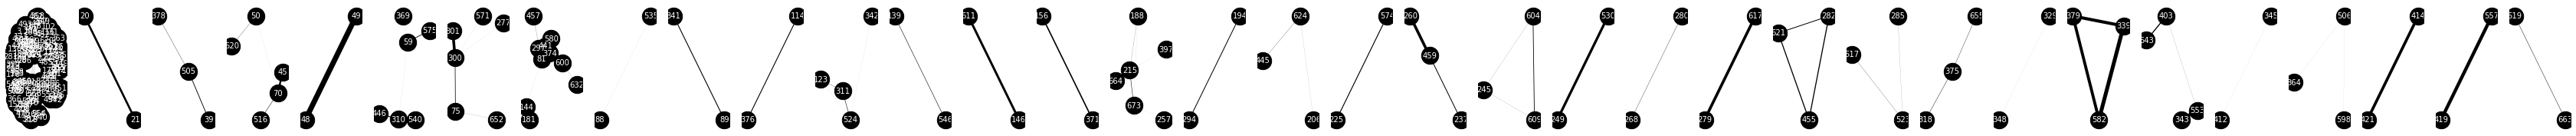

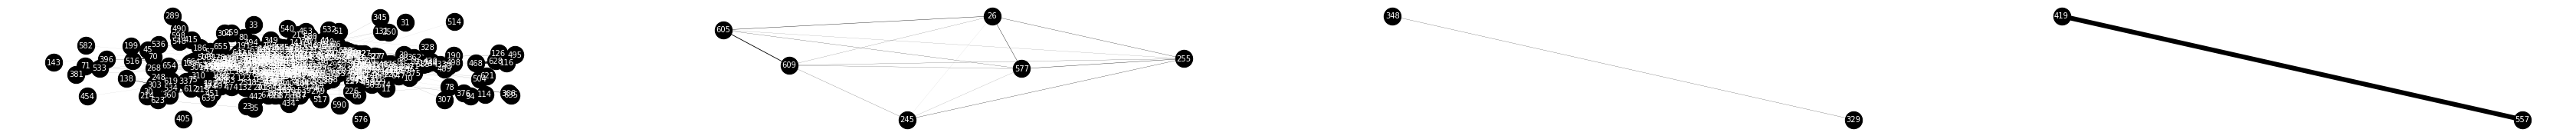

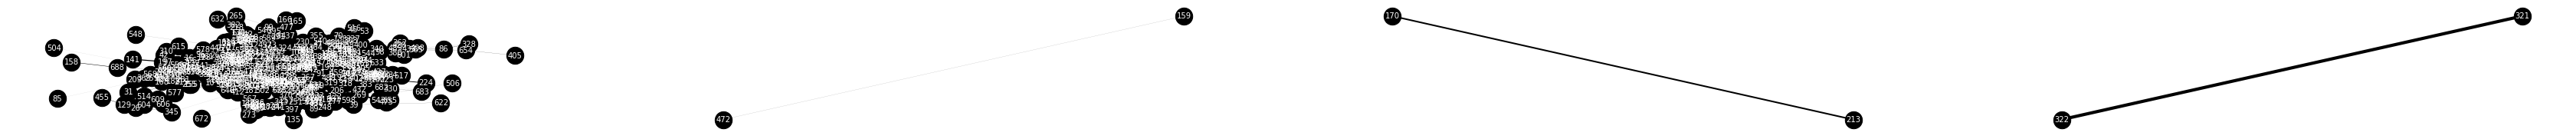

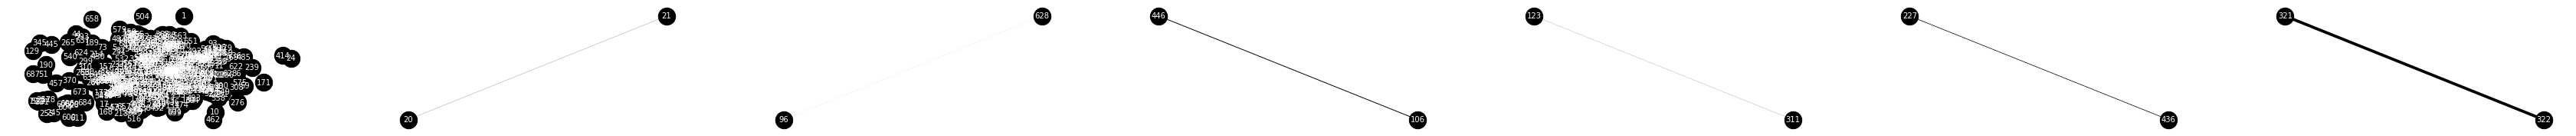

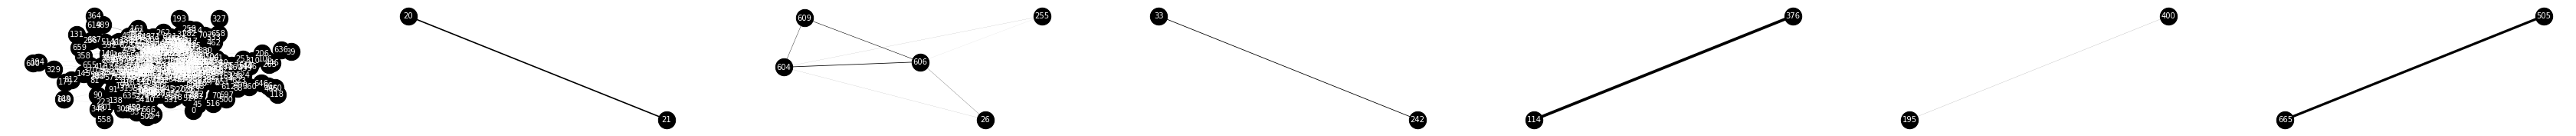

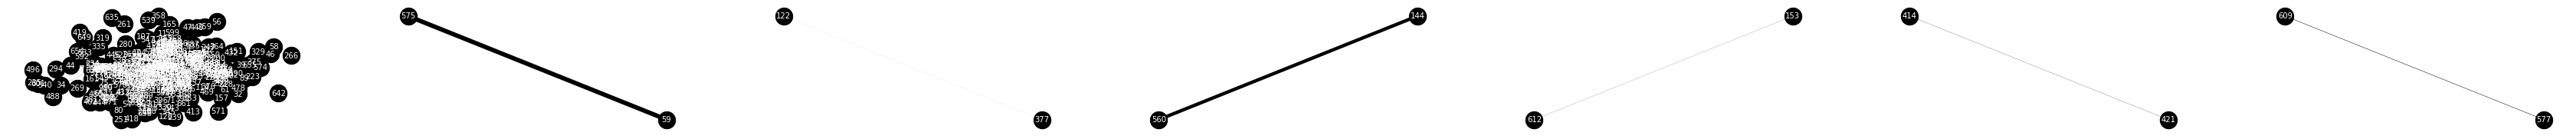

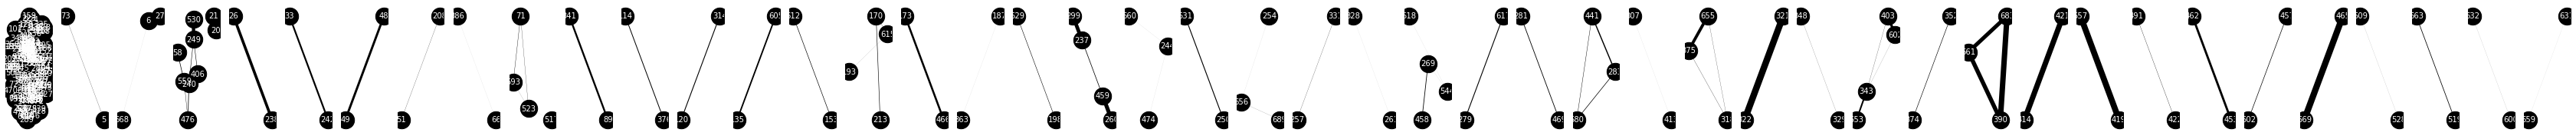

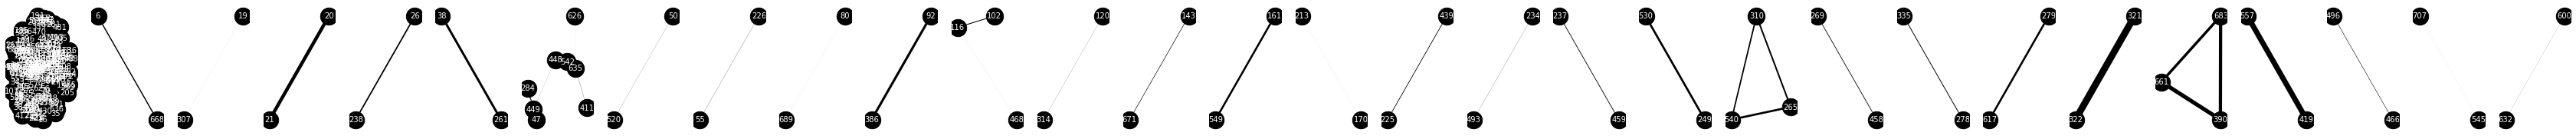

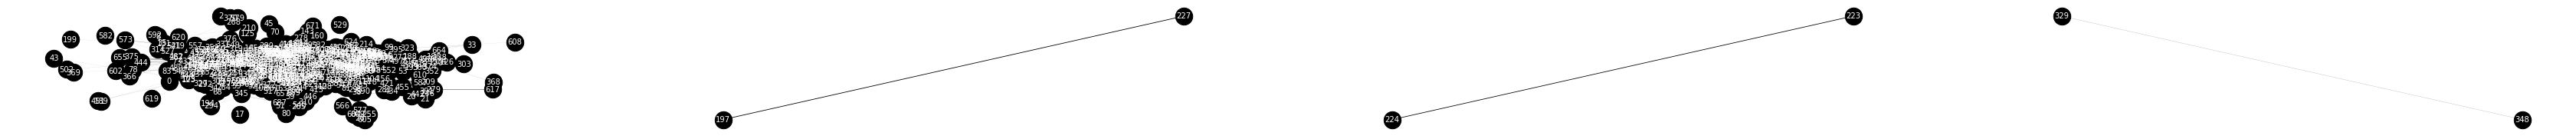

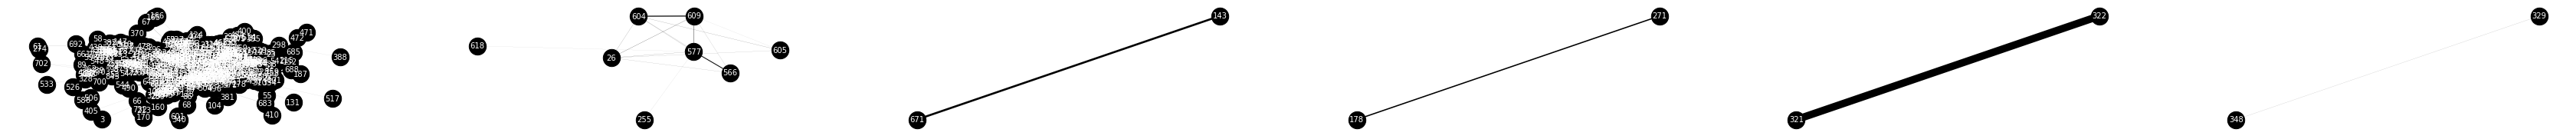

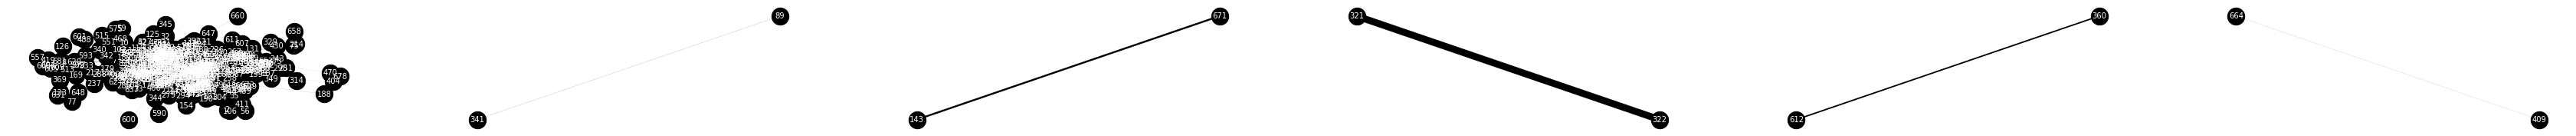

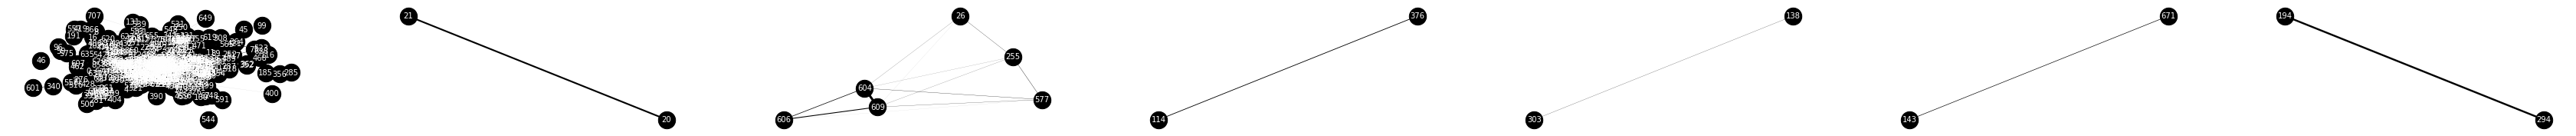

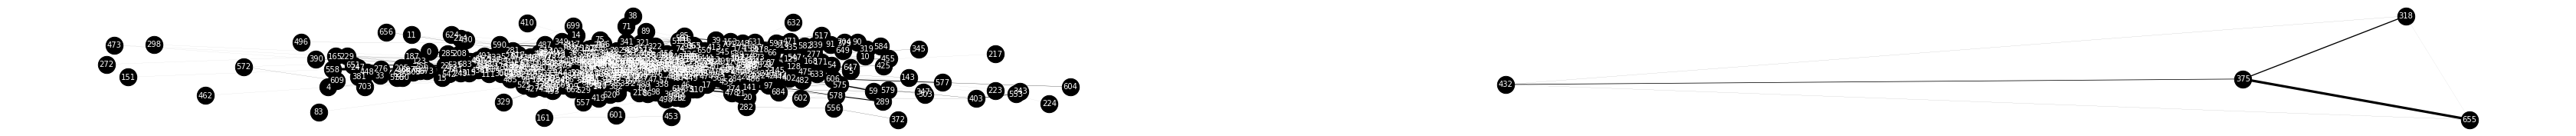

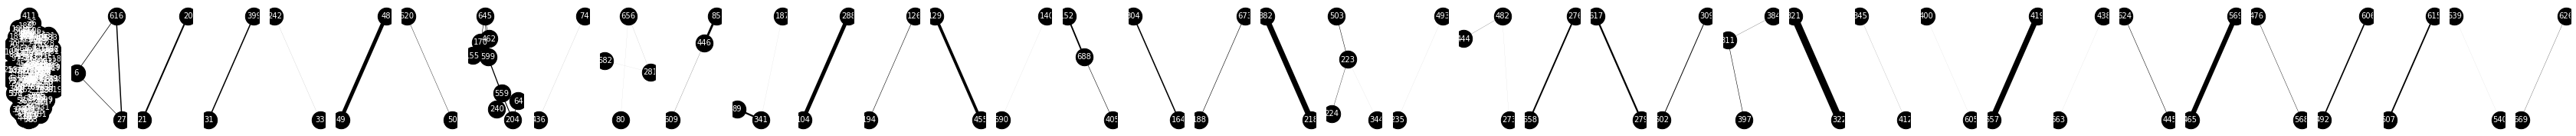

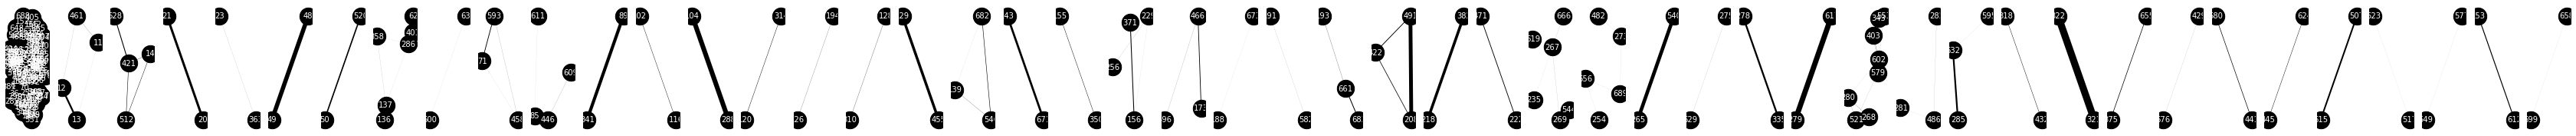

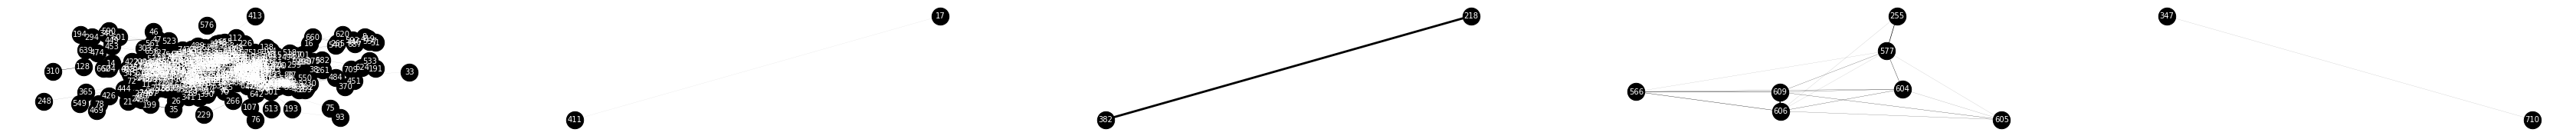

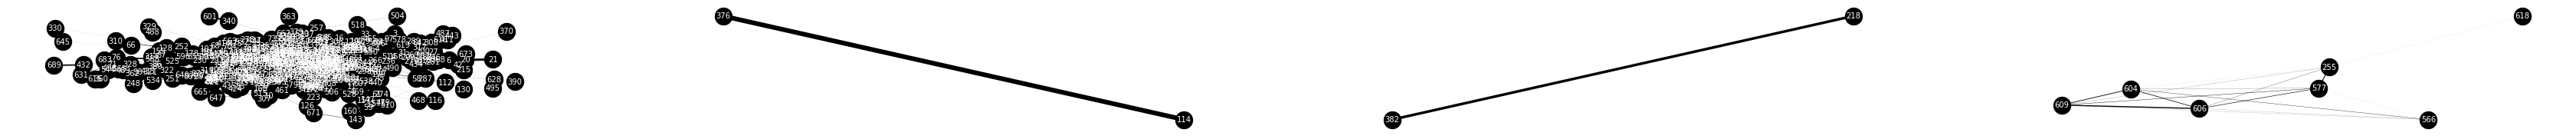

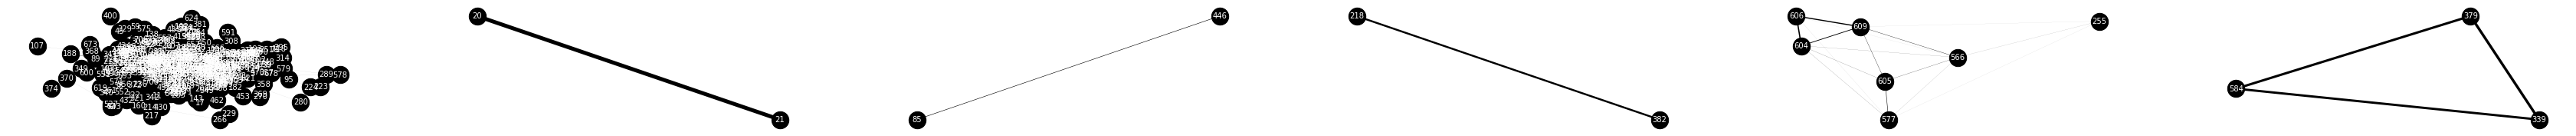

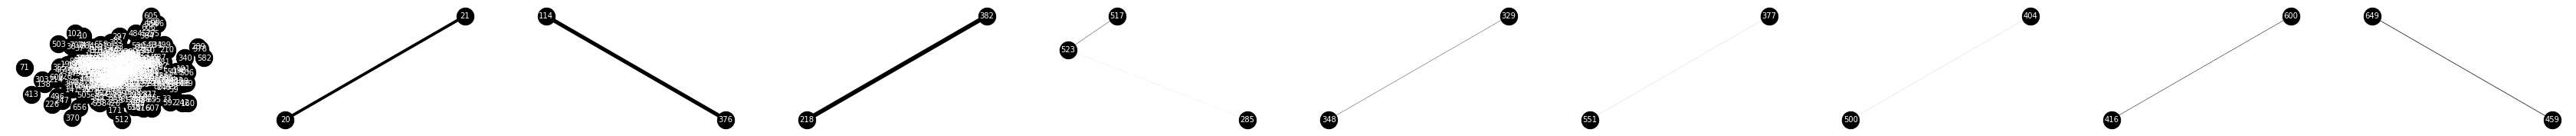

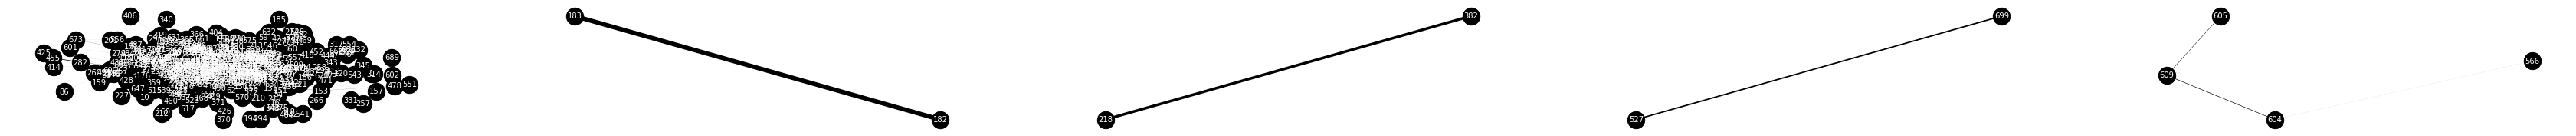

In [12]:
bt_24hr = aggregateStrongConnections(df_bt, 24)
graphs = createTimeGraphs(bt_24hr)
for i,G in enumerate(graphs):
    VisualizeBluetoothNetwork(G)
    if i == 19:
        break

### idee

- plottare la degree distribution dei vari nodi al variare dei giorni della settimana. E confrontare diversi plot su settimane diverse.

- studiare la variazione, in funzione della discretizzazione temporale (ore/giorni/...), la dimensione dei cluster più grande, e del numero di cluster.

- controllare se i cluster ottenuti nelle 6 ore notturne sono composti dagli stessi nodi dei cluster orari nelle ore notturne, anche al variare dei giorni

- per ogni nodo il degree medio giornaliero (come misura della "socialità"), e plottare la distribuzione al variare dei nodi di questo degree medio

## Largest cluster for different discretizations

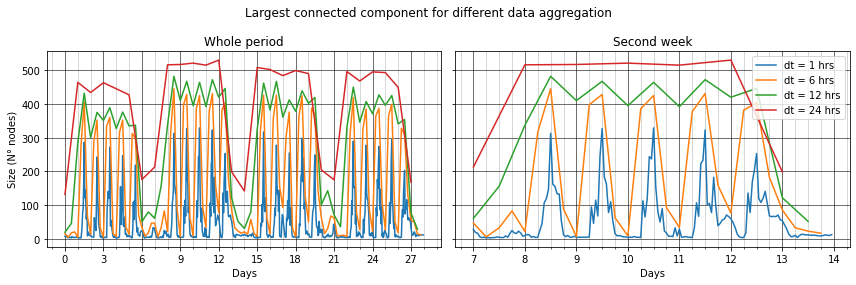

In [34]:
fig, axs = plt.subplots(1, 2, figsize=(12,4), sharey=True)
fig.suptitle("Largest connected component for different data aggregation")


for dt in [1, 6, 12, 24]:
    df = aggregateStrongConnections(df_bt, dt)
    graphs = createTimeGraphs(df)
    nodes_largest_cluster = [max([len(G.subgraph(c)) for c in nx.connected_components(G)]) for G in graphs]
    axs[0].plot(np.arange(len(graphs))*dt/24, nodes_largest_cluster, label=f"dt = {dt} hrs")
axs[0].set_title("Whole period")
axs[0].set_ylabel("Size (N° nodes)")
axs[0].set_xlabel("Days")
axs[0].set_xticks(np.linspace(0,27,10))
axs[0].xaxis.set_minor_locator(AutoMinorLocator(3))
axs[0].grid(True, which="major", c="black", alpha=0.7)
axs[0].grid(True, which="minor", c="black", alpha=0.2)


for dt in [1, 6, 12, 24]:
    second_week_slice = (df_bt["# timestamp"] >= 60*60*24*7) & (df_bt["# timestamp"] < 60*60*24*14)
    df = aggregateStrongConnections(df_bt[second_week_slice], dt)
    graphs = createTimeGraphs(df)
    nodes_largest_cluster = [max([len(G.subgraph(c)) for c in nx.connected_components(G)]) for G in graphs]
    axs[1].plot(np.arange(len(graphs))*dt/24+7, nodes_largest_cluster, label=f"dt = {dt} hrs")
axs[1].set_title("Second week")
axs[1].set_xlabel("Days")
axs[1].set_xticks(np.arange(0,7.5,1)+7)
axs[1].xaxis.set_minor_locator(AutoMinorLocator(4))
axs[1].grid(True, which="major", c="black", alpha=0.7)
axs[1].grid(True, which="minor", c="black", alpha=0.2)
axs[1].legend()


fig.tight_layout()
fig.savefig("plots/largest_cc.pdf")

Dal primo grafico possiamo osservare che la seconda settimana è quella in cui l'esperimento ha probabilmente dato i risultati migliori. La prima risentiva ancora della novità e le ultime due della minor dedizione dei partecipanti.

Dal secondo grafico possiamo riconoscere come mezzogiorno sia l'orario in cui avvengono la maggior parte dei contatti, probabilmente dovuto al fatto che gli studenti vanno a mangiare tutti negli stessi luoghi e si riuniscono per fare socialità. La dimensione della componente connessa più grande esplode in corrispondenza di questi orari.

Si nota inoltre che verso il fine settimana, nelle giornate di giovedì e venerdì (giorni 11 e 12) anche il pomeriggio e la sera costituiscono un momento di buona aggregazione, probabilmente per feste serali.

Infine durante le ore diurne la dimensione della componente connessa più grande si mantiene costantemente alta, interpretabile con il fatto che a lezione molti studenti sono a contatto ravvicinato.

## Sociality distribution of nodes

The sociality is measured as the average daily rate of interactions of a node with the others in the experiment. The sociality distribution is then plotted to check if there are few popular nodes.

In [29]:
bt_24hr = aggregateStrongConnections(df_bt, 24)
graphs = createTimeGraphs(bt_24hr)

[ 12  48  52  92 100 149 208 235 243 373 386 401 491 553 560 682 688]


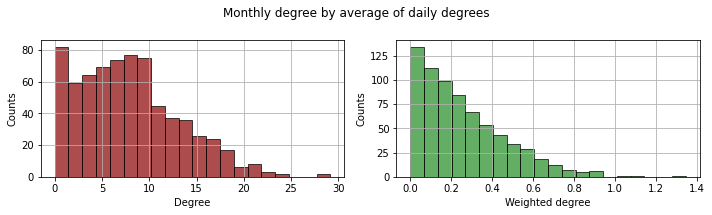

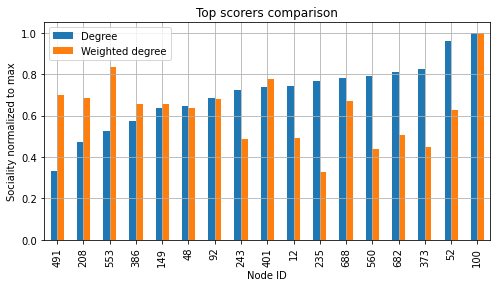

In [30]:
# sociality = number of contacts
list_of_df = [pd.DataFrame.from_dict(dict(graphs[i].degree()), orient="index") for i in range(28)]
df = pd.concat(list_of_df, axis="columns", ignore_index=True).fillna(0)
mean_dailysociality = df.mean(axis=1)
# sociality = weighted number of contacts
list_of_df = [pd.DataFrame.from_dict(dict(graphs[i].degree(weight="weight")), orient="index") for i in range(28)]
df = pd.concat(list_of_df, axis="columns", ignore_index=True).fillna(0)
mean_weighteddailysociality = df.mean(axis=1)
# plot sociality distribution
fig, axs = plt.subplots(1, 2, figsize=(10,3))
mean_dailysociality.hist(bins=20, color="darkred", alpha=0.7, edgecolor="black", linewidth=1, ax=axs[0])
axs[0].set_xlabel("Degree")
mean_weighteddailysociality.hist(bins=20, color="forestgreen", alpha=0.7, edgecolor="black", linewidth=1, ax=axs[1])
axs[1].set_xlabel("Weighted degree")
for ax in axs:
    ax.set_ylabel("Counts")

fig.suptitle("Monthly degree by average of daily degrees")
fig.tight_layout()
fig.savefig("plots/monthly_sociality_bymean.pdf")
    
# comparison between top 10 scorer in both distributions
top_scorers = np.unique(
    np.append(
        mean_dailysociality.sort_values().index[-10::],
        mean_weighteddailysociality.sort_values().index[-10::]
    )
)
print(top_scorers)
fig, ax = plt.subplots(figsize=(8,4))
to_plot = pd.concat(
    [
        mean_dailysociality[top_scorers] / mean_dailysociality[top_scorers].max(),
        mean_weighteddailysociality[top_scorers] / mean_weighteddailysociality[top_scorers].max(),
    ],
    axis="columns")
to_plot.columns = ["Degree", "Weighted degree"]
to_plot = to_plot.sort_values("Degree")
to_plot.plot(kind="bar", ax=ax)
ax.set_title("Top scorers comparison")
ax.set_xlabel("Node ID")
ax.set_ylabel("Sociality normalized to max")
ax.grid()

In [31]:
bt_1m = aggregateStrongConnections(df_bt, 24*28)
graphs = createTimeGraphs(bt_1m)

[ 12  13  25  48  52  81  88  92 100 149 208 235 283 386 401 491 553 560
 682 688]


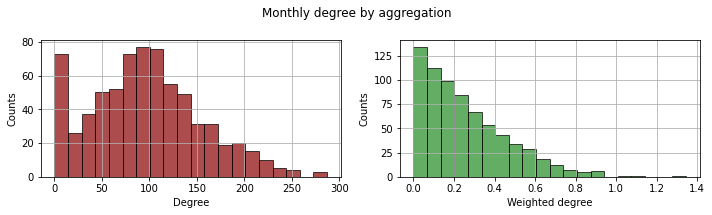

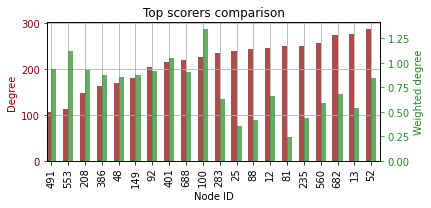

In [32]:
# sociality = number of contacts
monthly_sociality = pd.DataFrame.from_dict(dict(graphs[0].degree()), orient="index").fillna(0)[0]
# sociality = weighted number of contacts
monthly_weightedsociality = pd.DataFrame.from_dict(dict(graphs[0].degree(weight="weight")), orient="index").fillna(0)[0]
# plot sociality distribution
fig, axs = plt.subplots(1, 2, figsize=(10,3))
monthly_sociality.hist(bins=20, color="darkred", alpha=0.7, edgecolor="black", linewidth=1, ax=axs[0])
axs[0].set_xlabel("Degree")
monthly_weightedsociality.hist(bins=20, color="forestgreen", alpha=0.7, edgecolor="black", linewidth=1, ax=axs[1])
axs[1].set_xlabel("Weighted degree")
for ax in axs:
    ax.set_ylabel("Counts")

fig.suptitle("Monthly degree by aggregation")
fig.tight_layout()
fig.savefig("plots/monthly_sociality.pdf")


# comparison between top 10 scorer in both distributions
top_scorers = np.unique(
    np.append(
        monthly_sociality.sort_values().index[-10::],
        monthly_weightedsociality.sort_values().index[-10::]
    )
)
print(top_scorers)
fig, ax = plt.subplots(figsize=(6,3))
to_plot = pd.concat(
    [
        monthly_sociality[top_scorers],
        monthly_weightedsociality[top_scorers]
    ],
    axis="columns")
to_plot.columns = ["Degree", "Weighted degree"]
to_plot = to_plot.sort_values("Degree")
to_plot["Degree"].plot(kind="bar", color="darkred", alpha=0.7, align="edge", width=-0.3, ax=ax)
to_plot["Weighted degree"].plot(kind="bar", color="forestgreen", alpha=0.7, align="edge", width=-0.3, ax=ax)
ax2 = ax.twinx()
to_plot["Weighted degree"].plot(kind="bar", color="forestgreen", alpha=0.7, align="edge", width=0.3, ax=ax2)
ax.set_title("Top scorers comparison")
ax.set_xlabel("Node ID")
ax.set_ylabel("Degree", color="darkred")
ax.tick_params(axis='y', colors='darkred')
ax2.set_ylabel("Weighted degree", color="forestgreen")
ax2.tick_params(axis='y', colors='forestgreen')
ax.grid()
fig.tight_layout()
fig.savefig("plots/degree_topscorers.pdf")

# Hour-aggregation comparison at different moments

- monday morning
- wednesday at lunchtime
- tuesday at night
- friday evening
- thursday afternoon
- sunday afternoon

In [38]:
bt_1hr = aggregateStrongConnections(df_bt, 1)
graphs_at_hour = [
    createTimeGraphs(bt_1hr[bt_1hr["# timestamp"] == getTimestamp(1, 1, 10)])[0], # second monday morning
    createTimeGraphs(bt_1hr[bt_1hr["# timestamp"] == getTimestamp(1, 3, 12)])[0], # second wednesday at lunchtime
    createTimeGraphs(bt_1hr[bt_1hr["# timestamp"] == getTimestamp(1, 2,  4)])[0], # second tuesday at night
    createTimeGraphs(bt_1hr[bt_1hr["# timestamp"] == getTimestamp(1, 5, 22)])[0], # second friday evening
    createTimeGraphs(bt_1hr[bt_1hr["# timestamp"] == getTimestamp(1, 4, 16)])[0], # second thursday afternoon
    createTimeGraphs(bt_1hr[bt_1hr["# timestamp"] == getTimestamp(1, 0, 18)])[0]  # second sunday afternoon
]

In [13]:
indices = [np.argmax([len(cc) for cc in nx.connected_components(G)])
           for G in graphs_at_hour]
biggest_cc = [G.subgraph(cc) for i,G in enumerate(graphs_at_hour)
              for j,cc in enumerate(nx.connected_components(G))
              if j == indices[i]]

## Degree distribution

### On the whole slice

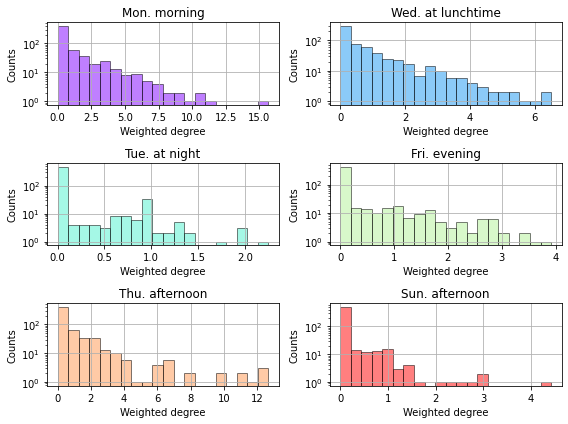

In [39]:
fig, axs = plt.subplots(3, 2, figsize=(8,6))
axs = axs.flatten()

titles = ["Mon. morning", "Wed. at lunchtime", "Tue. at night",
          "Fri. evening", "Thu. afternoon", "Sun. afternoon"]
colors = plt.cm.get_cmap("rainbow", 6)
for i,G in enumerate(graphs_at_hour):
    degrees = pd.DataFrame.from_dict(dict(G.degree(weight="weight")), orient="index")[0]
    degrees.hist(bins=20, ax=axs[i], color=colors(i), alpha=0.5, edgecolor="black", linewidth=1)
    axs[i].set_title(titles[i])
for ax in axs:
    ax.set_xlabel("Weighted degree")
    ax.set_ylabel("Counts")
    ax.set_yscale("log")

fig.tight_layout()
fig.savefig("plots/deg_distr_diff_hours.pdf")

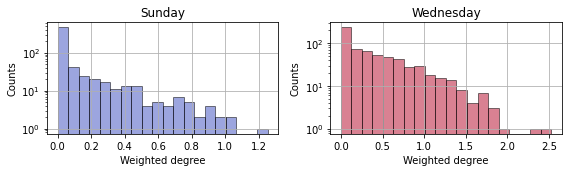

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(8,2.5))

bt_24hr = aggregateStrongConnections(df_bt, 24)
graphs_at_days = [
    createTimeGraphs(bt_24hr[bt_24hr["# timestamp"] == getTimestamp(1, 0, 0)])[0], # second sunday
    createTimeGraphs(bt_24hr[bt_24hr["# timestamp"] == getTimestamp(1, 3, 0)])[0], # second wednesday
]
colors = plt.cm.get_cmap("coolwarm", 2)
titles = ["Sunday", "Wednesday"]
for i,G in enumerate(graphs_at_days):
    degrees = pd.DataFrame.from_dict(dict(G.degree(weight="weight")), orient="index")[0]
    degrees.hist(bins=20, ax=axs[i], color=colors(i), alpha=0.5, edgecolor="black", linewidth=1)
    axs[i].set_title(titles[i])

for ax in axs:
    ax.set_xlabel("Weighted degree")
    ax.set_ylabel("Counts")
    ax.set_yscale("log")

fig.tight_layout()
fig.savefig("plots/deg_distr_diff_days.pdf")

In [10]:
titles_1m = ["Entire month"]
colors_1m = ["forestgreen"]

titles_1d = ["Sunday", "Wednesday"]
colors_1d = plt.cm.get_cmap("coolwarm", 2)

titles_1h = ["Mon. morning", "Wed. at lunchtime", "Tue. at night",
             "Fri. evening", "Thu. afternoon", "Sun. afternoon"]
colors_1h = plt.cm.get_cmap("rainbow", 6)

In [11]:
bt_1m = aggregateStrongConnections(df_bt, 24*28)
bt_1m_selected = bt_1m
graphs_1m = createTimeGraphs(bt_1m_selected)

bt_1d = aggregateStrongConnections(df_bt, 24)
bt_1d_selected = bt_1d.set_index("# timestamp").loc[[getTimestamp(1,i,0) for i in [0,3]]].reset_index()
graphs_1d = createTimeGraphs(bt_1d_selected)

bt_1h = aggregateStrongConnections(df_bt, 1)
days, hours = [1,3,2,5,4,0], [10,12,4,22,16,18]
bt_1h_selected = bt_1h.set_index("# timestamp").loc[[getTimestamp(1,i,j) for i,j in zip(days,hours)]].reset_index()
graphs_1h = createTimeGraphs(bt_1h_selected)

- closeness
rappresenta quanto è vicino ogni nodo a tutti gli altri, ossia quanto è probabile che un pettegolezzo gli giunga all'orecchio

- betweenness
rappresenta quanto è probabile che l'amicizia tra due altri nodi passi anche per il nodo in questione, ossia quanto rapidamente gli giungono pettegolezzi. un collegamento tra due nodi passi attraverso quel nodo. I nodi che eccellono, sono anche quelli la cui assenza (malattia o dipartita) è più nociva per la rete di amicizie

- clustering
rappresenta quanto il nodo tende a fare cluster coi suoi vicini. Alto punteggio significa che gli amici del nodo sono anche tutti amici tra loro

- average_clustering
rappresenta quanto è piena di persone senza gruppi la rete (più è basso e più c'è gente senza gruppo).

- attribute assortativity
rappresenta quanto i maschi tendono a fare gruppo tra maschi e le femmine tra femmine

- degree assortativity
rappresenta quanto gente popolare tende a fare gruppo con gente popolare.

- community detection (girvan_newman)

## Closeness

In [26]:
closeness_1m = pd.concat(
    [
        pd.DataFrame.from_dict(
            nx.closeness_centrality(G, distance="distance"), orient="index", columns=[titles_1m[i]]
        )
        for i,G in enumerate(graphs_1m)
    ],
    axis="columns"
)

closeness_1d = pd.concat(
    [
        pd.DataFrame.from_dict(
            nx.closeness_centrality(G, distance="distance"), orient="index", columns=[titles_1d[i]]
        )
        for i,G in enumerate(graphs_1d)
    ],
    axis="columns"
)

closeness_1h = pd.concat(
    [
        pd.DataFrame.from_dict(
            nx.closeness_centrality(G, distance="distance"), orient="index", columns=[titles_1h[i]]
        )
        for i,G in enumerate(graphs_1h)
    ],
    axis="columns"
)

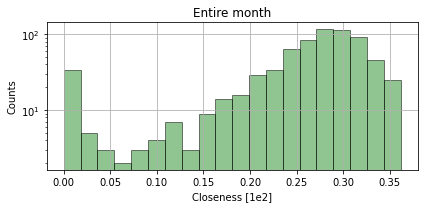

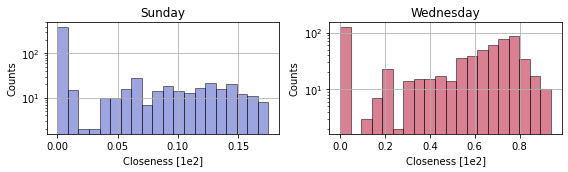

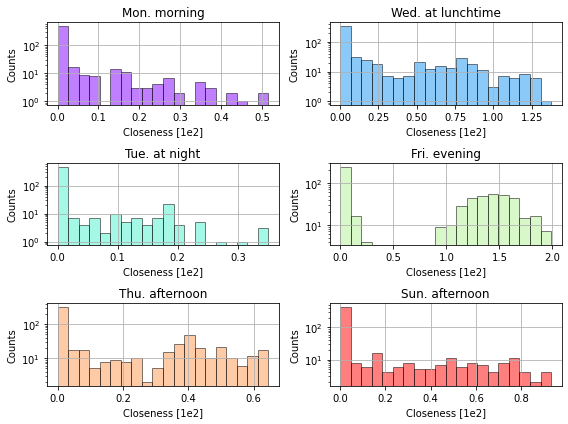

In [27]:
fig, ax = plt.subplots(1,1,figsize=(6,3))

(closeness_1m*100).hist(bins=20, color=colors_1m[0], alpha=0.5, edgecolor="black", linewidth=1, ax=ax)

ax.set_title(titles_1m[0])
ax.set_xlabel("Closeness [1e2]")
ax.set_ylabel("Counts")
ax.set_yscale("log")

fig.tight_layout()
fig.savefig("plots/monthly_closeness.pdf")




fig, axs = plt.subplots(1,2,figsize=(8,2.5))

for i,col in enumerate(closeness_1d):
    (closeness_1d[col]*100).hist(bins=20, color=colors_1d(i), alpha=0.5, edgecolor="black", linewidth=1, ax=axs[i])

for i,ax in enumerate(axs):
    ax.set_title(titles_1d[i])
    ax.set_xlabel("Closeness [1e2]")
    ax.set_ylabel("Counts")
    ax.set_yscale("log")

fig.tight_layout()
fig.savefig("plots/daily_closeness.pdf")




fig, axs = plt.subplots(3,2,figsize=(8,6))
axs = axs.flatten()

for i,col in enumerate(closeness_1h):
    (closeness_1h[col]*100).hist(bins=20, color=colors_1h(i), alpha=0.5, edgecolor="black", linewidth=1, ax=axs[i])

for i,ax in enumerate(axs):
    ax.set_title(titles_1h[i])
    ax.set_xlabel("Closeness [1e2]")
    ax.set_ylabel("Counts")
    ax.set_yscale("log")

fig.tight_layout()
fig.savefig("plots/hourly_closeness.pdf")

## Betweenness

In [28]:
betweenness_1m = pd.concat(
    [
        pd.DataFrame.from_dict(
            nx.betweenness_centrality(G, weight="weight"), orient="index", columns=[titles_1m[i]]
        )
        for i,G in enumerate(graphs_1m)
    ],
    axis="columns"
)

betweenness_1d = pd.concat(
    [
        pd.DataFrame.from_dict(
            nx.betweenness_centrality(G, weight="weight"), orient="index", columns=[titles_1d[i]]
        )
        for i,G in enumerate(graphs_1d)
    ],
    axis="columns"
)

betweenness_1h = pd.concat(
    [
        pd.DataFrame.from_dict(
            nx.betweenness_centrality(G, weight="weight"), orient="index", columns=[titles_1h[i]]
        )
        for i,G in enumerate(graphs_1h)
    ],
    axis="columns"
)

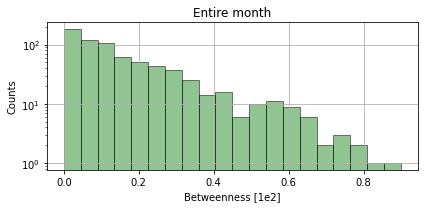

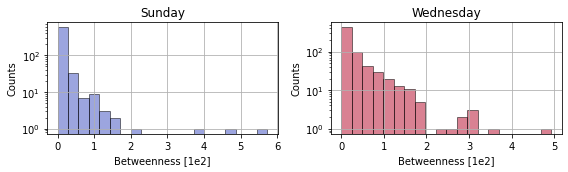

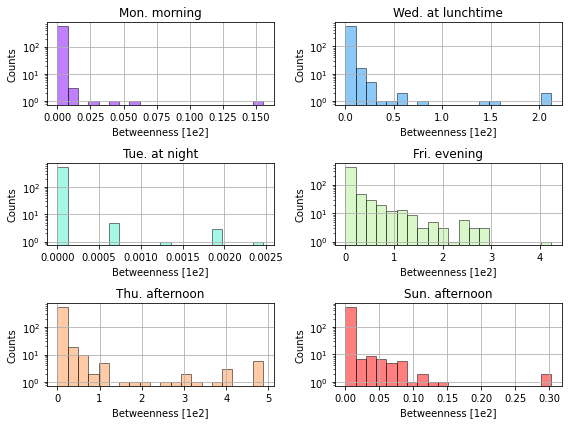

In [29]:
fig, ax = plt.subplots(1,1,figsize=(6,3))

(betweenness_1m*100).hist(bins=20, color=colors_1m[0], alpha=0.5, edgecolor="black", linewidth=1, ax=ax)

ax.set_title(titles_1m[0])
ax.set_xlabel("Betweenness [1e2]")
ax.set_ylabel("Counts")
ax.set_yscale("log")

fig.tight_layout()
fig.savefig("plots/monthly_betweenness.pdf")




fig, axs = plt.subplots(1,2,figsize=(8,2.5))

for i,col in enumerate(betweenness_1d):
    (betweenness_1d[col]*100).hist(bins=20, color=colors_1d(i), alpha=0.5, edgecolor="black", linewidth=1, ax=axs[i])

for i,ax in enumerate(axs):
    ax.set_title(titles_1d[i])
    ax.set_xlabel("Betweenness [1e2]")
    ax.set_ylabel("Counts")
    ax.set_yscale("log")

fig.tight_layout()
fig.savefig("plots/daily_betweenness.pdf")




fig, axs = plt.subplots(3,2,figsize=(8,6))
axs = axs.flatten()

for i,col in enumerate(betweenness_1h):
    (betweenness_1h[col]*100).hist(bins=20, color=colors_1h(i), alpha=0.5, edgecolor="black", linewidth=1, ax=axs[i])

for i,ax in enumerate(axs):
    ax.set_title(titles_1h[i])
    ax.set_xlabel("Betweenness [1e2]")
    ax.set_ylabel("Counts")
    ax.set_yscale("log")

fig.tight_layout()
fig.savefig("plots/hourly_betweenness.pdf")

## Clustering

In [30]:
clustering_1m = pd.concat(
    [
        pd.DataFrame.from_dict(
            nx.clustering(G, weight="weight"), orient="index", columns=[titles_1m[i]]
        )
        for i,G in enumerate(graphs_1m)
    ],
    axis="columns"
)

clustering_1d = pd.concat(
    [
        pd.DataFrame.from_dict(
            nx.clustering(G, weight="weight"), orient="index", columns=[titles_1d[i]]
        )
        for i,G in enumerate(graphs_1d)
    ],
    axis="columns"
)

clustering_1h = pd.concat(
    [
        pd.DataFrame.from_dict(
            nx.clustering(G, weight="weight"), orient="index", columns=[titles_1h[i]]
        )
        for i,G in enumerate(graphs_1h)
    ],
    axis="columns"
)

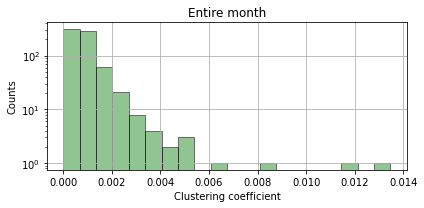

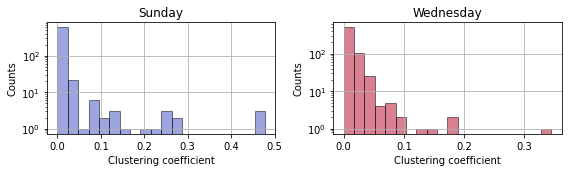

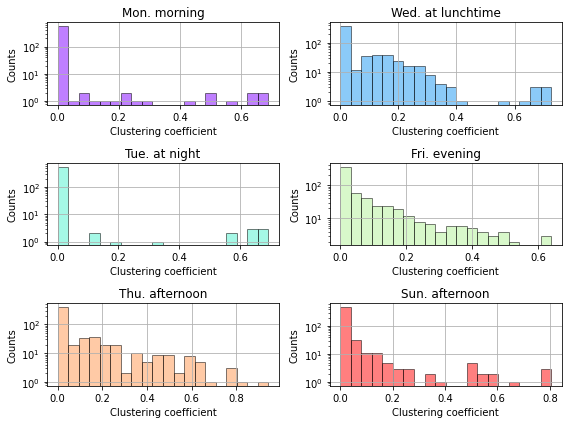

In [31]:
fig, ax = plt.subplots(1,1,figsize=(6,3))

clustering_1m.hist(bins=20, color=colors_1m[0], alpha=0.5, edgecolor="black", linewidth=1, ax=ax)

ax.set_title(titles_1m[0])
ax.set_xlabel("Clustering coefficient")
ax.set_ylabel("Counts")
ax.set_yscale("log")

fig.tight_layout()
fig.savefig("plots/monthly_clustering.pdf")




fig, axs = plt.subplots(1,2,figsize=(8,2.5))

for i,col in enumerate(clustering_1d):
    clustering_1d[col].hist(bins=20, color=colors_1d(i), alpha=0.5, edgecolor="black", linewidth=1, ax=axs[i])

for i,ax in enumerate(axs):
    ax.set_title(titles_1d[i])
    ax.set_xlabel("Clustering coefficient")
    ax.set_ylabel("Counts")
    ax.set_yscale("log")

fig.tight_layout()
fig.savefig("plots/daily_clustering.pdf")




fig, axs = plt.subplots(3,2,figsize=(8,6))
axs = axs.flatten()

for i,col in enumerate(clustering_1h):
    clustering_1h[col].hist(bins=20, color=colors_1h(i), alpha=0.5, edgecolor="black", linewidth=1, ax=axs[i])

for i,ax in enumerate(axs):
    ax.set_title(titles_1h[i])
    ax.set_xlabel("Clustering coefficient")
    ax.set_ylabel("Counts")
    ax.set_yscale("log")

fig.tight_layout()
fig.savefig("plots/hourly_clustering.pdf")

## Attribute assortativity

In [32]:
attrassortativity_1m = [nx.attribute_assortativity_coefficient(G, "gender") for G in graphs_1m]

attrassortativity_1d = [nx.attribute_assortativity_coefficient(G, "gender") for G in graphs_1d]

attrassortativity_1h = [nx.attribute_assortativity_coefficient(G, "gender") for G in graphs_1h]

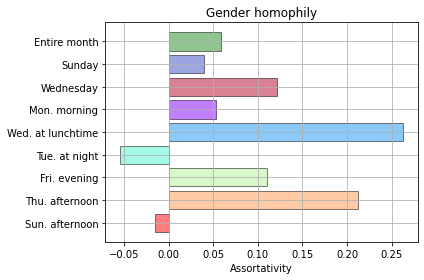

In [33]:
fig, ax = plt.subplots(1,1,figsize=(6,4))

labels = titles_1m + titles_1d + titles_1h
attrassortativities = attrassortativity_1m + attrassortativity_1d + attrassortativity_1h
bars = ax.barh(np.arange(len(labels)), attrassortativities, align='center', alpha=0.5, edgecolor="black", linewidth=1)
for i,bar in enumerate(bars):
    if i == 0:
        bar.set_facecolor(colors_1m[i])
    elif i <= 2:
        bar.set_facecolor(colors_1d(i-1))
    else:
        bar.set_facecolor(colors_1h(i-3))
ax.set_yticks(np.arange(len(labels)), labels=labels)
ax.invert_yaxis()  # labels read top-to-bottom

ax.set_title("Gender homophily")
ax.set_xlabel("Assortativity")
ax.grid()

fig.tight_layout()
fig.savefig("plots/gender_homophily.pdf")

## Degree assortativity

In [34]:
degassortativity_1m = [nx.degree_assortativity_coefficient(G, weight="weight") for G in graphs_1m]

degassortativity_1d = [nx.degree_assortativity_coefficient(G, weight="weight") for G in graphs_1d]

degassortativity_1h = [nx.degree_assortativity_coefficient(G, weight="weight") for G in graphs_1h]

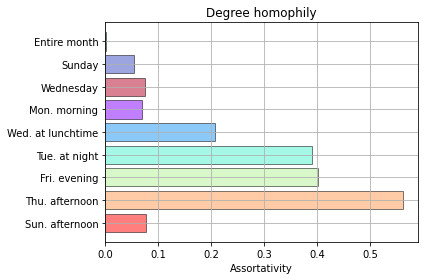

In [35]:
fig, ax = plt.subplots(1,1,figsize=(6,4))

labels = titles_1m + titles_1d + titles_1h
degassortativities = degassortativity_1m + degassortativity_1d + degassortativity_1h
bars = ax.barh(np.arange(len(labels)), degassortativities, align='center', alpha=0.5, edgecolor="black", linewidth=1)
for i,bar in enumerate(bars):
    if i == 0:
        bar.set_facecolor(colors_1m[i])
    elif i <= 2:
        bar.set_facecolor(colors_1d(i-1))
    else:
        bar.set_facecolor(colors_1h(i-3))
ax.set_yticks(np.arange(len(labels)), labels=labels)
ax.invert_yaxis()  # labels read top-to-bottom

ax.set_title("Degree homophily")
ax.set_xlabel("Assortativity")
ax.grid()

fig.tight_layout()
fig.savefig("plots/degree_homophily.pdf")

## Community detection

In [12]:
community_1m = [nx.algorithms.community.louvain_communities(G, weight="weight", resolution=10) for G in graphs_1m]

community_1d = [nx.algorithms.community.louvain_communities(G, weight="weight", resolution=10) for G in graphs_1d]

community_1h = [nx.algorithms.community.louvain_communities(G, weight="weight", resolution=1) for G in graphs_1h]

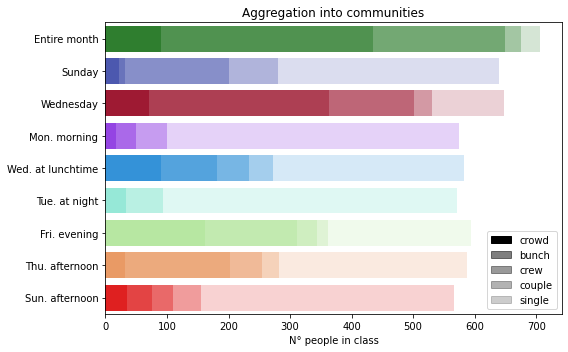

In [37]:
def histCommunitiesOccupation(communities):
    hist = {"crowd":0, "bunch":0, "crew":0, "couple":0, "single":0}
    for S in communities:
        if len(S) <= 1:
            hist["single"] = hist["single"] + len(S)
        elif len(S) <= 2:
            hist["couple"] = hist["couple"] + len(S)
        elif len(S) <= 8:
            hist["crew"] = hist["crew"] + len(S)
        elif len(S) <= 20:
            hist["bunch"] = hist["bunch"] + len(S)
        else:
            hist["crowd"] = hist["crowd"] + len(S)
    return hist

fig, ax = plt.subplots(figsize=(8,5))

labels = titles_1m + titles_1d + titles_1h
palette = sb.color_palette(
    colors_1m +
    [matplotcolors.rgb2hex(x) for i,x in enumerate(colors_1d._lut) if i<len(colors_1d._lut)-3] +
    [matplotcolors.rgb2hex(x) for i,x in enumerate(colors_1h._lut) if i<len(colors_1h._lut)-3]
)
alphas = [0.2,0.3,0.4,0.5,1][::-1]
hist_list = [histCommunitiesOccupation(lst) for lst in community_1m+community_1d+community_1h]
hist_df = pd.DataFrame.from_dict(hist_list)
hist_df.index = labels
hist_df_cumsum = hist_df.apply(np.cumsum, axis=1)
hist_dict = {col:hist_df_cumsum[[col]].T.melt() for col in hist_df_cumsum}
for i,subdata in enumerate(hist_dict.values()):
    sb.barplot(data=subdata, x="value", y="variable", ci=None, palette=palette, orient="h", alpha=alphas[i], ax=ax)
ax.set_ylabel("")
ax.set_xlabel("N° people in class")
legend_list = [matplotpatches.Patch(color="black", alpha=alphas[i], label=hist_df.columns[i]) for i,a in enumerate(alphas)]
ax.legend(handles=legend_list)
ax.set_title("Aggregation into communities")
fig.tight_layout()
fig.savefig("plots/community_detection.pdf")

In [29]:
titles = titles_1m + titles_1d + titles_1h
interesting_nodes = [[98,495], [98,420,362,495], (90,91), (136,137), (48,49), (218,382)]
for i,communities in enumerate(community_1m+community_1d+community_1h):
    print(f"For {titles[i]}")
    for nodes in interesting_nodes:
        print(f"nodes {nodes} are present in the community: ", end="")
        for community in communities:
            if np.all([x in community for x in nodes]):
                print(community, end="")
        print()
    print()

For Entire month
nodes [98, 495] are present in the community: {544, 98, 420, 328, 489, 362, 495, 433, 498, 565, 86, 380}
nodes [98, 420, 362, 495] are present in the community: {544, 98, 420, 328, 489, 362, 495, 433, 498, 565, 86, 380}
nodes (90, 91) are present in the community: {704, 631, 649, 90, 91, 318, 319}
nodes (136, 137) are present in the community: {454, 136, 137, 650, 235, 654, 597, 667, 350}
nodes (48, 49) are present in the community: {48, 49, 171}
nodes (218, 382) are present in the community: {32, 382, 510, 710, 528, 274, 147, 61, 469, 218, 347, 157, 478, 479}

For Sunday
nodes [98, 495] are present in the community: 
nodes [98, 420, 362, 495] are present in the community: 
nodes (90, 91) are present in the community: {90, 91}
nodes (136, 137) are present in the community: 
nodes (48, 49) are present in the community: {48, 49}
nodes (218, 382) are present in the community: 

For Wednesday
nodes [98, 495] are present in the community: {544, 33, 98, 328, 489, 495, 433, 4

In [18]:
[x in set([1,2,2,3,4,5,5,6,6,6,6,7,8]) for x in [1,10]]

[True, False]

In [60]:
males = [i for i,attr in nx.get_node_attributes(graphs_1m[0], "gender").items() if attr=="male"]
females = [i for i,attr in nx.get_node_attributes(graphs_1m[0], "gender").items() if attr=="female"]

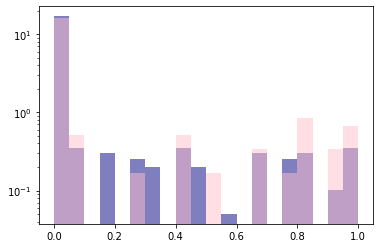

In [90]:
bins = np.linspace(0,1,21)
plt.hist(dict(graphs_1h[5].subgraph(males).degree(weight="weight")).values(), bins=bins, density=True, color="navy", alpha=0.5)
plt.hist(dict(graphs_1h[5].subgraph(females).degree(weight="weight")).values(), bins=bins, density=True, color="pink", alpha=0.5)
plt.yscale("log")

### For the largest connected component

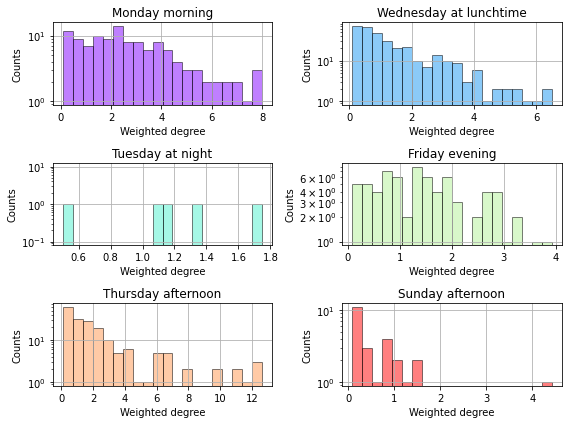

In [68]:
fig, axs = plt.subplots(3, 2, figsize=(8,6))
axs = axs.flatten()

titles = ["Monday morning", "Wednesday at lunchtime", "Tuesday at night",
          "Friday evening", "Thursday afternoon", "Sunday afternoon"]
colors = plt.cm.get_cmap("rainbow", 6)
for i,G in enumerate(biggest_cc):
    degrees = pd.DataFrame.from_dict(dict(G.degree(weight="weight")), orient="index")[0]
    degrees.hist(bins=20, ax=axs[i], color=colors(i), alpha=0.5, edgecolor="black", linewidth=1)
    axs[i].set_title(titles[i])
for ax in axs:
    ax.set_xlabel("Weighted degree")
    ax.set_ylabel("Counts")
    ax.set_yscale("log")

fig.tight_layout()
fig.savefig("plots/deg_distr_diff_hours.pdf")

## degree distribution on different days

In [50]:
bt_24hr = aggregateStrongConnections(df_bt, 24)
graphs = createTimeGraphs(bt_24hr)

0.9895833333333333
2.875
2.5451388888888893
2.3020833333333335
3.003472222222223
1.6736111111111112
1.2743055555555558
1.253472222222223
2.309027777777778
2.6805555555555562
2.5243055555555554
3.4791666666666665
1.9965277777777783
2.302083333333334
1.2083333333333333
2.8993055555555562
2.09375
2.902777777777779
2.03125
1.7430555555555558
1.892361111111111
1.0486111111111112
2.277777777777778
2.6875
2.2361111111111116
2.0138888888888893
2.197916666666667
1.9375


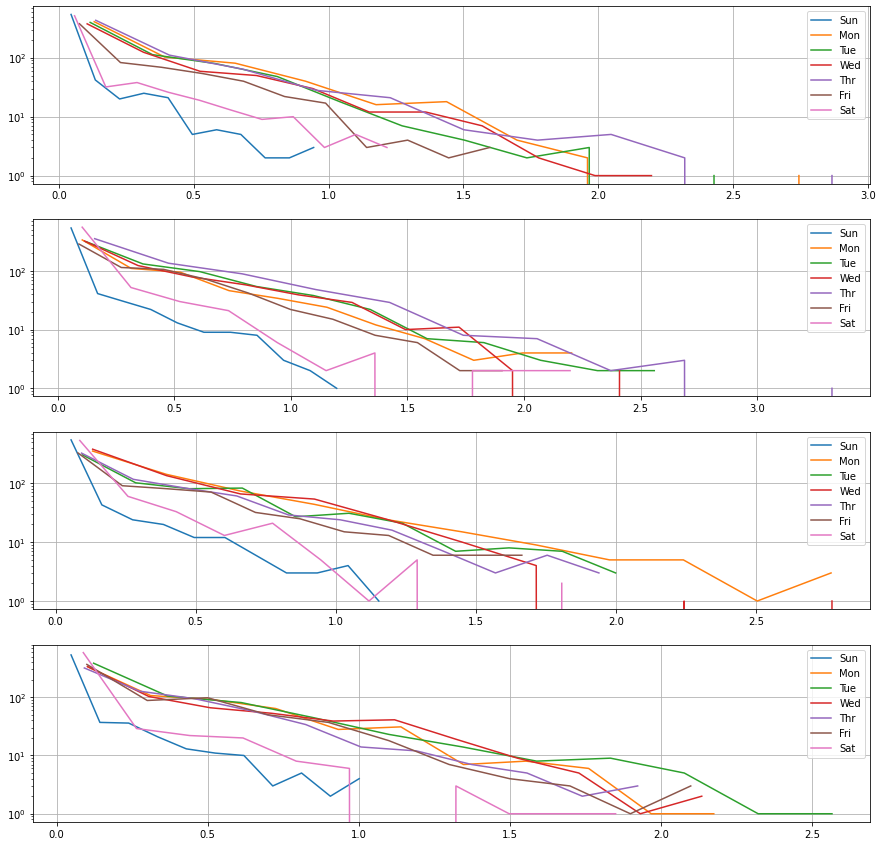

In [67]:
list_of_df = [pd.DataFrame.from_dict(dict(graphs[i].degree(weight="weight")), orient="index") for i in range(28)]
df = pd.concat(list_of_df, axis="columns", ignore_index=True).fillna(0)
fig, axs = plt.subplots(4,1,figsize=(15,15))
i = 0
labels = ["Sun","Mon","Tue","Wed","Thr","Fri","Sat"]
for day in df:
    if i % 7 == 0:
        ax = axs[i//7]
    print(df[day].max())
    counts,bins = np.histogram(df[day], bins=11)#np.logspace(-1,0,10))
    ax.plot((bins[1:]+bins[:-1])/2, counts, label=labels[i%7])
    #df[day].hist(ax=ax, alpha=0.3)
    i = i + 1

for ax in axs:
#    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.legend()
    ax.grid(True)